In [ ]:
import pandas as pd
import random
from random import choices
import pdb
from collections import Counter
import math
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from scipy.stats import gengamma
from datetime import datetime

from typing import Dict
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.stats import poisson
from scipy.stats import gengamma
import networkx as nx #for the powerlaw network
import csv

#Timestamp
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

#OBSERVED DATA
data2 = pd.read_csv('cascade_distribution_de.csv', delim_whitespace=True)
y=np.array(data2.loc[:,"number"])
norm_y = y
max_val2 = max(y)
data = norm_y/max_val2


def simulate_networks(form1, scale1, form2, scale2):
    f1=form1/10
    s1=scale1/10000
    f2=form2/10
    s2=scale2/10000
    
    N: int = 1400 #number of users in the network
    mean_degree: int = 15
    
    G= nx.barabasi_albert_graph(N,1)
    degrees = dict(G.degree())
    node_degrees: np.array = np.empty(N)
    
    for i in range(N):
        node_degrees[i]=degrees[i]
    node_degrees = node_degrees.astype(int)
    
    node_ids: np.array = np.arange(N)
    adjacency_list = []
    
    for i in range(len(node_degrees)):
        adjacency_list1: Dict[int, np.array] = dict()
        adjacency_list.append(adjacency_list1)    
    
    for i in range(len(node_degrees)):
        adjacency_list[0][i] = np.random.choice(node_ids, node_degrees[i]) #random sample from node_ids with size=node_degrees1[meme_id]
    
    #print('2')
    tick = 0
    tick_max: int = 70
    max_time: int = 500
    M: int = 1200 #5387880 - tamanho do dataset alemão
    meme_ids: np.array = np.arange(M)
    meme_sizes: np.array = np.zeros(M)
    meme_sizes = meme_sizes.astype(int)
    times: np.array = np.full(M, max_time)
    
    #dr = []
    #tp = []
    #at_tr = []
    
    for meme_id in meme_ids:
        #print(meme_id, '/', len(meme_ids))
        time: int = times[meme_id]
        
        infected: np.array = np.random.choice(node_ids,1)
        exposed = []
        plotinf = []
        
        
        tran_prob: float = gengamma.rvs(2*form1, form1, 0, scale1, size=1)[0]
        #decrease_rate: float = gengamma.rvs(a=ggd_a, c=ggd_c, loc=ggd_loc, scale=ggd_scale, size=1)[0] / 9
        decrease_rate: float = gengamma.rvs(2*form2, form2, 0, scale2, size=1)[0]
        #dr = np.append(dr, decrease_rate)
        #tp = np.append(tp, tran_prob)
        
        
        #g = open("sim_memes_v7_2.txt", "a")
        
        for t in range(time):
            #f = open("sim_v6_cas4.txt", "a")
            
            transmission_probability: float = tran_prob * math.exp(-decrease_rate*t)
            
            #at_tr = np.append(at_tr, transmission_probability)
            
            for i in range(len(infected)):
                exposed=adjacency_list[0][infected[i]]
                number_infected: int = np.random.poisson(lam=1*transmission_probability * len(exposed), size=1)[0]
                #sem o fator multiplicativo não há nodos suficientes a serem selecionados para info se propagar
                
                if number_infected > 0:  
                    choice_number = min(number_infected, len(exposed))
                    choice = np.random.choice(exposed, choice_number, replace=False)
                    
                    for k in range(len(choice)):
                        if (choice[k] in infected)  == False:
                            infected = np.append(infected, choice[k])
                            tick = 0
                
                if tick>tick_max:
                    break
                
                tick = tick+1
                    
            #L = [str(t), " ",str(len(infected)), "\n"]
            #f.writelines(L)
            #f.close()
            #plotinf = np.append(plotinf, len(infected))
        
        meme_sizes[meme_id]= len(infected)
        
        #L = [str(meme_id), " ", str(len(infected)), " ", str(tran_prob), " ", str(decrease_rate), " ", str(transmission_probability), "\n"]
        #g.writelines(L)
        #g.close()
        
        infected = []
        exposed = []
            
    counter1 = Counter(meme_sizes)
    memes_unnorm = np.array(list(counter1.values()))
    max_val = max(memes_unnorm)
    memes = memes_unnorm/max_val
    
    #PADDING PARA PODER COMPARAR
    
    #Len Data = 187
    
    #if len(memes)>187:
    #    memes=memes[0:187]
    #else:
    #    missing=187-len(memes)
    #    memes_missing=np.zeros(missing)
    #    memes=np.concatenate((memes, memes_missing), axis=None)
    
    np.asarray(memes,dtype=object)
    
    return memes

def my_stat(x):
    a1 = x[0]/x[1]
    a2 = (x[1]/x[2])*1.5
    a3 = (x[2]/x[3])*2
    a4 = (x[0]/x[8])/50
    a5 = x[2]/x[8]
    return np.array([a1, a2, a3, a4, a5], dtype=object)

with pm.Model() as gamma_de:
    
    print('a')
    
    form1 = pm.Uniform("form1", lower=3, upper=100)
    scale1 = pm.Uniform("scale1", lower=1, upper=300)
    form2 = pm.Uniform("form2", lower=3, upper=100)
    scale2 = pm.Uniform("scale2", lower=1, upper=300)
    
    
    #Últimos Valore Usados, acho
    #form1 = pm.Uniform("form1", lower=0.7, upper=4)
    #scale1 = pm.Uniform("scale1", lower=0.5, upper=18)
    #form2 = pm.Uniform("form2", lower=0.005, upper=0.16)
    #scale2 = pm.Uniform("scale2", lower=0.005, upper=0.37)
    
    #form1 = pm.Uniform("form1", lower=0.65, upper=1.7)
    #scale1 = pm.Uniform("scale1", lower=0.1, upper=15)
    #form2 = pm.Uniform("form2", lower=0.7, upper=1.3)
    #scale2 = pm.Uniform("scale2", lower=0.0001, upper=0.4)
    
    s = pm.Simulator("s", simulate_networks, params=[form1, scale1, form2, scale2],
                     sum_stat=my_stat,  
                     epsilon=10,
                     observed=norm_y)
    #trace, sim_data = pm.sample_smc(draws=10, kernel="ABC", cores=6, parallel=True, save_sim_data=True)
    
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    
    trace, sim_data = pm.sample_smc(draws=400, kernel="ABC", cores=10, parallel=True, save_sim_data=True)
    
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    
    idata = az.from_pymc3(trace, posterior_predictive=sim_data)
        
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

#17:41:27 2/5
#form 0.04 scale 0.1
#intervalo original 2.9

Current Time = 16:19:35
a


Initializing SMC sampler...
Sampling 10 chains in 10 jobs


Current Time = 16:19:35


/home/phccduarte/venv2/myenv2/lib/python3.10/site-packages/pymc3/smc/smc.py:383: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.sim_data_l)
/home/phccduarte/venv2/myenv2/lib/python3.10/site-packages/pymc3/smc/smc.py:383: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.sim_data_l)
/home/phccduarte/venv2/myenv2/lib/python3.10/site-packages/pymc3/smc/smc.py:383: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths

In [29]:
idata.to_netcdf("abc_4_par.nc") #netcdf4

ValueError: setting an array element with a sequence.

Current Time = 22:34:08
Current Time = 22:34:09


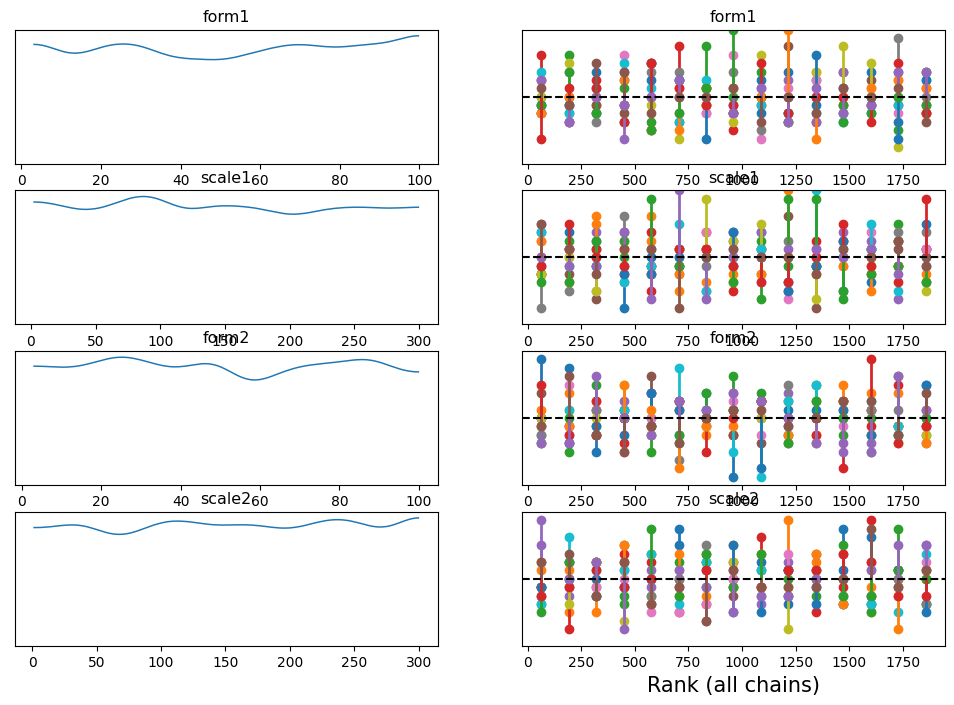

In [30]:
from datetime import datetime
import arviz as az

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

az.plot_trace(idata, kind="rank_vlines", combined=True)

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [25]:
datt = idata.to_dataframe

In [26]:
pm.save_trace(trace=trace,
directory= r"")

ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, pymc3 trace, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not method

In [ ]:
with model_nb:
t_nb = pm.load_trace(
directory=r"c:\Users\xxx\Documents\xxx\traces\trace_nb")

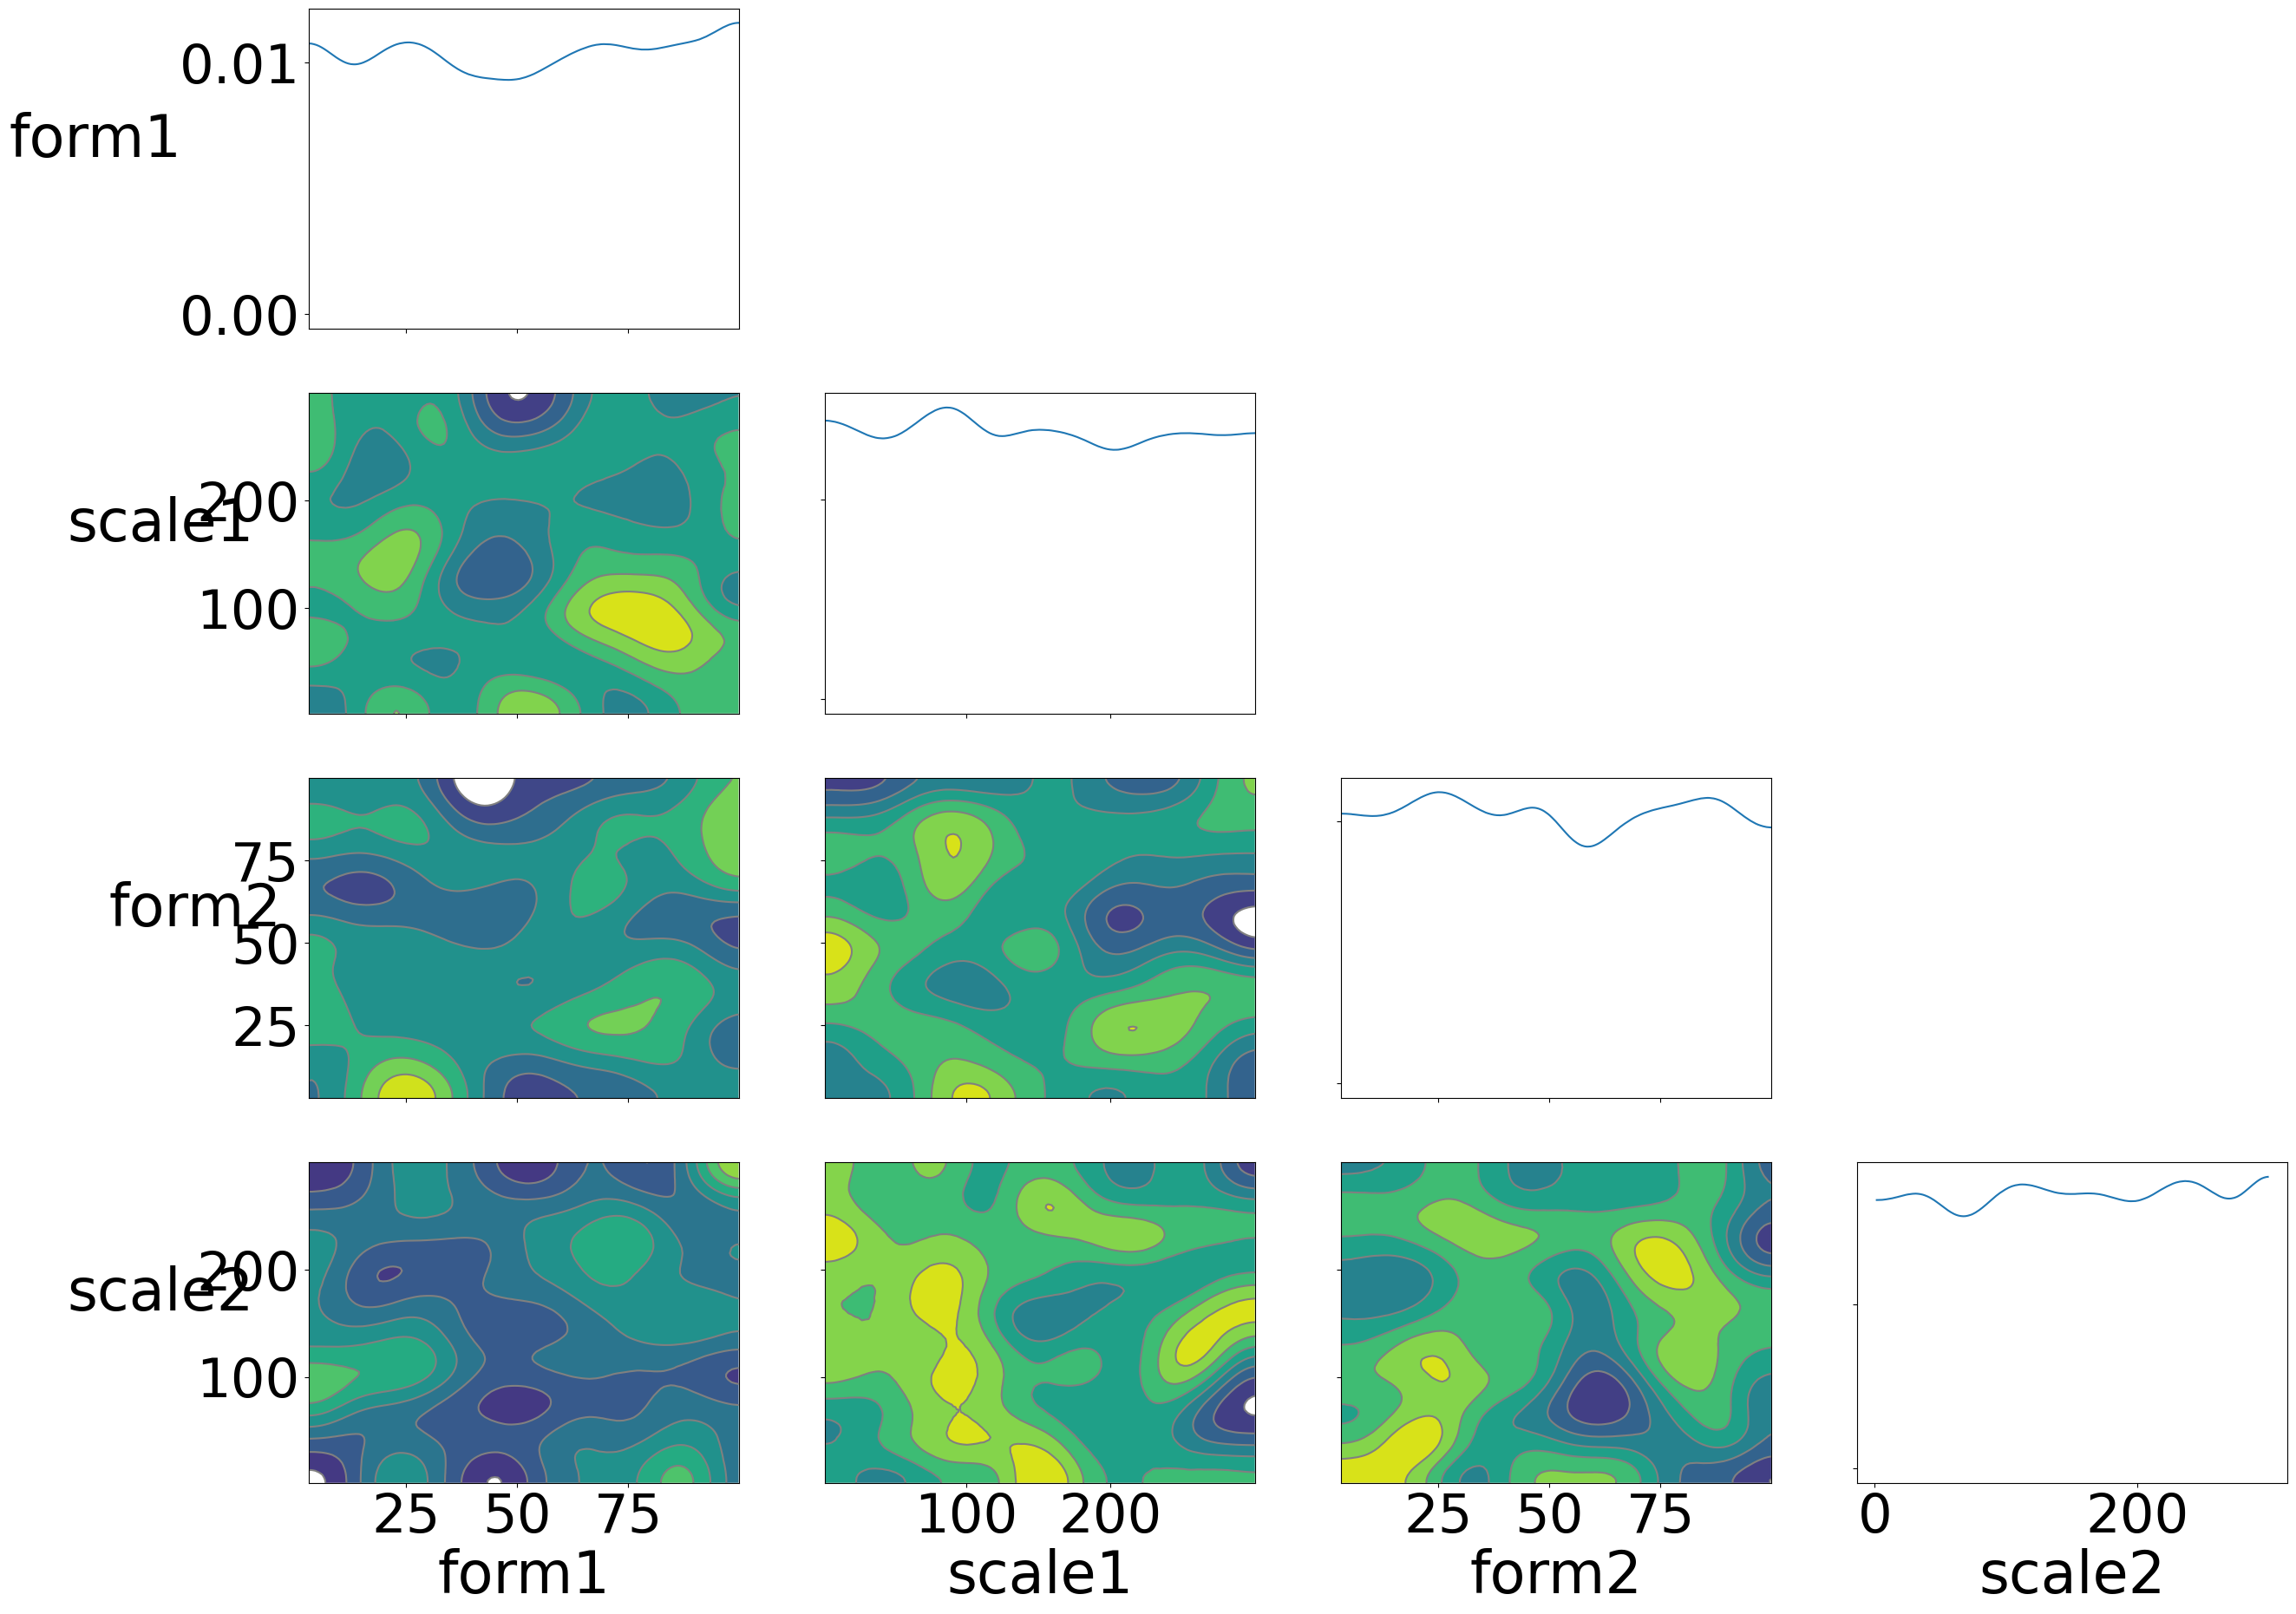

In [21]:
axes = az.plot_pair(idata, 
                    kind="kde", 
                    marginals=True,
                    textsize=45,
                    kde_kwargs={"contourf_kwargs":{"cmap":plt.cm.viridis}},
                    )

for ax, pad in zip(axes[:,0], (70, 30, 30, 30)):
    ax.set_ylabel(ax.get_ylabel(), rotation=0, labelpad=pad)

#plt.savefig("img/chp08/pair_gk.png")

In [5]:
idata2 = az.from_netcdf("4_par_nl_v1.nc")

array([[<AxesSubplot:title={'center':'form1'}>,
        <AxesSubplot:title={'center':'form1'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'scale1'}>,
        <AxesSubplot:title={'center':'scale1'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'form2'}>,
        <AxesSubplot:title={'center':'form2'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'scale2'}>,
        <AxesSubplot:title={'center':'scale2'}, xlabel='Rank (all chains)'>]],
      dtype=object)

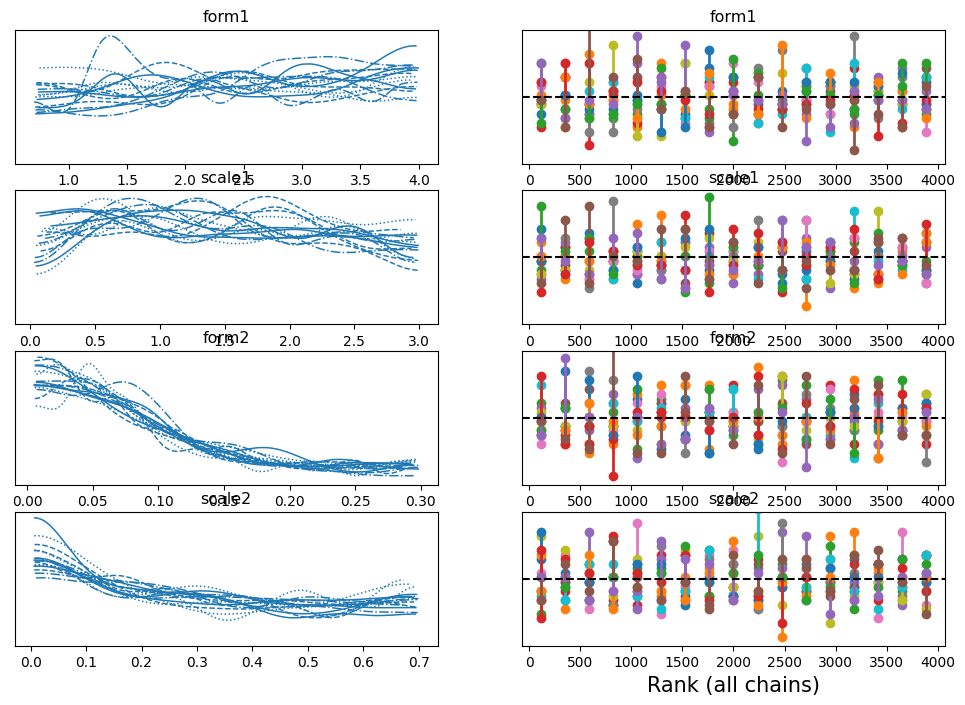

In [7]:
az.plot_trace(idata2, kind="rank_vlines", combined=False)

In [3]:
print('u')

u
